# Uber and Lyft Prices Prediction
By: Group 7

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install tsfresh
import tsfresh
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.inspection import permutation_importance
from tsfresh import extract_features
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute
import time
from sklearn.ensemble import RandomForestRegressor
from tensorflow.keras import layers, Sequential
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
cab = pd.read_csv("/content/drive/Shared drives/Python Project /cab_rides.csv")
weather = pd.read_csv("/content/drive/Shared drives/Python Project /weather.csv")

#Weather EDA

1. three tables
2. some plots

In [ ]:
weather.head()

,temp,location,clouds,pressure,rain,time_stamp,humidity,wind
0,42.42,Back Bay,1.0,1012.14,0.1228,1545003901,0.77,11.25
1,42.43,Beacon Hill,1.0,1012.15,0.1846,1545003901,0.76,11.32
2,42.50,Boston University,1.0,1012.15,0.1089,1545003901,0.76,11.07
3,42.11,Fenway,1.0,1012.13,0.0969,1545003901,0.77,11.09
4,43.13,Financial District,1.0,1012.14,0.1786,1545003901,0.75,11.49


In [ ]:
weather['date_time'] = pd.to_datetime(weather['time_stamp'], unit='s')
weather['date_time'] = weather['date_time'].dt.strftime('%Y-%m-%d %H')
weather['date_time'] = pd.to_datetime(weather['date_time'])
weather.head()

,temp,location,clouds,pressure,rain,time_stamp,humidity,wind,date_time
0,42.42,Back Bay,1.0,1012.14,0.1228,1545003901,0.77,11.25,2018-12-16 23:00:00
1,42.43,Beacon Hill,1.0,1012.15,0.1846,1545003901,0.76,11.32,2018-12-16 23:00:00
2,42.50,Boston University,1.0,1012.15,0.1089,1545003901,0.76,11.07,2018-12-16 23:00:00
3,42.11,Fenway,1.0,1012.13,0.0969,1545003901,0.77,11.09,2018-12-16 23:00:00
4,43.13,Financial District,1.0,1012.14,0.1786,1545003901,0.75,11.49,2018-12-16 23:00:00


In [ ]:
weather['date'] = weather.date_time.dt.date
weather['hour'] = weather.date_time.dt.hour
weather= weather.drop(['time_stamp'], axis=1)
weather.head()

,temp,location,clouds,pressure,rain,humidity,wind,date_time,date,hour
0,42.42,Back Bay,1.0,1012.14,0.1228,0.77,11.25,2018-12-16 23:00:00,2018-12-16,23
1,42.43,Beacon Hill,1.0,1012.15,0.1846,0.76,11.32,2018-12-16 23:00:00,2018-12-16,23
2,42.50,Boston University,1.0,1012.15,0.1089,0.76,11.07,2018-12-16 23:00:00,2018-12-16,23
3,42.11,Fenway,1.0,1012.13,0.0969,0.77,11.09,2018-12-16 23:00:00,2018-12-16,23
4,43.13,Financial District,1.0,1012.14,0.1786,0.75,11.49,2018-12-16 23:00:00,2018-12-16,23


In [ ]:
#missing value 
weather['rain'].fillna(0,inplace=True)

In [ ]:
weather_location = weather[['temp','clouds', 'pressure', 'rain', 'humidity',
       'wind']].groupby(weather['location']).agg(['min', 'mean', 'max'])
weather_location= pd.DataFrame(weather_location)
weather_location

temp                    ...  wind                 
                           min       mean    max  ...   min      mean    max
location                                          ...                       
Back Bay                 19.92  39.082122  55.28  ...  0.30  6.778528  17.96
Beacon Hill              19.96  39.047285  55.22  ...  0.30  6.810325  17.88
Boston University        19.62  39.047744  55.28  ...  0.30  6.692180  17.81
Fenway                   19.66  38.964379  55.37  ...  0.30  6.711721  17.84
Financial District       20.11  39.410822  55.28  ...  0.30  6.860019  18.11
Haymarket Square         20.06  39.067897  55.28  ...  0.30  6.843193  18.16
North End                20.12  39.090841  55.29  ...  0.30  6.853117  18.18
North Station            19.93  39.035315  55.32  ...  0.30  6.835755  18.09
Northeastern University  19.79  38.975086  55.41  ...  0.30  6.749426  17.84
South Station            20.10  39.394092  55.33  ...  0.29  6.848948  18.08
Theatre District         19.97  38.986711  55.38  ...  0.30  6.834302  18.04
West End                 19.88  38.983403  55.29  ...  0.30  6.816233  18.12

[12 rows x 18 columns]

In [ ]:
weather_mean = weather.groupby(['location','date', 'hour']).mean()
weather_mean= pd.DataFrame(weather_mean)
weather_mean.reset_index(inplace=True)
weather_mean

,location,date,hour,temp,clouds,pressure,rain,humidity,wind
0,Back Bay,2018-11-26,3,41.040000,0.870000,1014.390000,0.0,0.920000,1.460000
1,Back Bay,2018-11-26,4,40.658000,0.894000,1014.008000,0.0,0.926000,2.646000
2,Back Bay,2018-11-26,5,40.561250,0.930000,1013.821250,0.0,0.921250,2.496250
3,Back Bay,2018-11-26,6,40.627333,0.990667,1014.196667,0.0,0.913333,1.350667
4,Back Bay,2018-11-26,7,41.137500,0.970000,1014.292500,0.0,0.920000,1.735000
...,...,...,...,...,...,...,...,...,...
3955,West End,2018-12-18,14,26.190000,0.480000,1010.120000,0.0,0.470000,13.890000
3956,West End,2018-12-18,15,27.220000,0.340000,1011.420000,0.0,0.460000,15.030000
3957,West End,2018-12-18,16,28.700000,0.310000,1011.480000,0.0,0.470000,14.600000
3958,West End,2018-12-18,17,30.050000,0.150000,1011.420000,0.0,0.460000,13.550000


In [ ]:
weather_date = weather[['temp','clouds', 'pressure', 'rain', 'humidity',
       'wind']].groupby(weather['date']).mean()
weather_date

,temp,clouds,pressure,rain,humidity,wind
date,,,,,,
2018-11-26,42.068838,0.957852,1013.256232,0.003969,0.904049,3.623850
2018-11-27,43.373713,0.899532,995.794591,0.060072,0.863260,10.051126
2018-11-28,37.161044,0.535654,992.202700,0.000054,0.729768,7.817173
2018-11-29,38.849635,0.533750,1000.920846,0.000114,0.672995,10.172448
2018-11-30,35.608267,0.290633,1015.535267,0.000000,0.713167,3.783233
2018-12-01,36.692160,0.648920,1020.901821,0.000059,0.705031,3.440309
2018-12-02,42.379549,0.875382,1014.668299,0.008200,0.892014,3.883021
2018-12-03,48.947778,0.752708,1000.748993,0.000473,0.804201,5.706424
2018-12-04,43.653889,0.329722,1003.416389,0.000000,0.619167,7.761667


In [ ]:
def highlight_max(data, color='yellow'):
    '''
    highlight the maximum in a Series or DataFrame
    '''
    attr = 'background-color: {}'.format(color)
    data = data.replace('%','', regex=True).astype(float)
    if data.ndim == 1: 
        is_max = data == data.max()
        return [attr if v else '' for v in is_max]
    else:  # from .apply(axis=None)
        is_max = data == data.max().max()
        return pd.DataFrame(np.where(is_max, attr, ''),
                            index=data.index, columns=data.columns)
weather_date.style.apply(highlight_max)

,temp,clouds,pressure,rain,humidity,wind
date,,,,,,
2018-11-26,42.068838,0.957852,1013.256232,0.003969,0.904049,3.623850
2018-11-27,43.373713,0.899532,995.794591,0.060072,0.863260,10.051126
2018-11-28,37.161044,0.535654,992.202700,0.000054,0.729768,7.817173
2018-11-29,38.849635,0.533750,1000.920846,0.000114,0.672995,10.172448
2018-11-30,35.608267,0.290633,1015.535267,0.000000,0.713167,3.783233
2018-12-01,36.692160,0.648920,1020.901821,0.000059,0.705031,3.440309
2018-12-02,42.379549,0.875382,1014.668299,0.008200,0.892014,3.883021
2018-12-03,48.947778,0.752708,1000.748993,0.000473,0.804201,5.706424
2018-12-04,43.653889,0.329722,1003.416389,0.000000,0.619167,7.761667


In [ ]:
weather_date.reset_index(inplace=True)

In [ ]:
weather_date

,date,temp,clouds,pressure,rain,humidity,wind
0,2018-11-26,42.068838,0.957852,1013.256232,0.003969,0.904049,3.623850
1,2018-11-27,43.373713,0.899532,995.794591,0.060072,0.863260,10.051126
2,2018-11-28,37.161044,0.535654,992.202700,0.000054,0.729768,7.817173
3,2018-11-29,38.849635,0.533750,1000.920846,0.000114,0.672995,10.172448
4,2018-11-30,35.608267,0.290633,1015.535267,0.000000,0.713167,3.783233
5,2018-12-01,36.692160,0.648920,1020.901821,0.000059,0.705031,3.440309
6,2018-12-02,42.379549,0.875382,1014.668299,0.008200,0.892014,3.883021
7,2018-12-03,48.947778,0.752708,1000.748993,0.000473,0.804201,5.706424
8,2018-12-04,43.653889,0.329722,1003.416389,0.000000,0.619167,7.761667
9,2018-12-09,30.692917,0.201667,1022.805000,0.000000,0.569583,5.530000


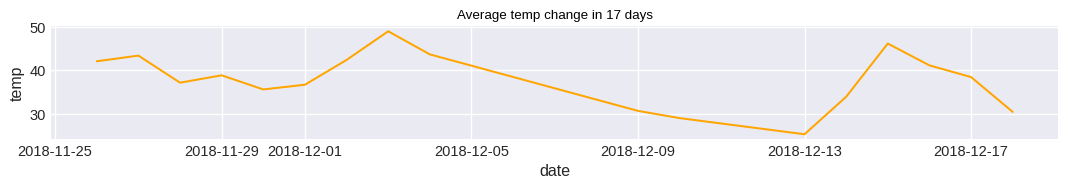

In [ ]:
plt.style.use('seaborn-darkgrid')
my_dpi=96
plt.figure(figsize=(1300/my_dpi, 150/my_dpi), dpi=my_dpi)
sns.lineplot(x=weather_date.date, y=weather_date.temp,color='orange')
plt.title("Average temp change in 17 days",fontsize=10, fontweight=0, color='black')
plt.show()

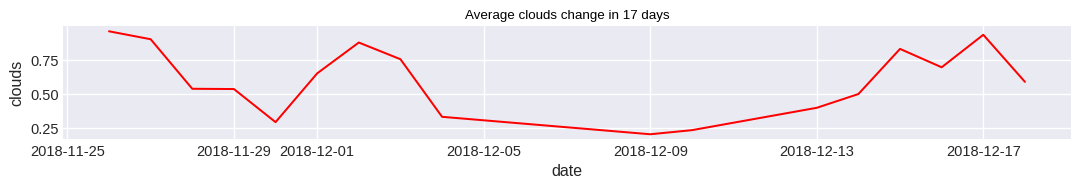

In [ ]:
plt.style.use('seaborn-darkgrid')
my_dpi=96
plt.figure(figsize=(1300/my_dpi, 150/my_dpi), dpi=my_dpi)
sns.lineplot(x=weather_date.date, y=weather_date.clouds,color='red')
plt.title("Average clouds change in 17 days",fontsize=10, fontweight=0, color='black')
plt.show()

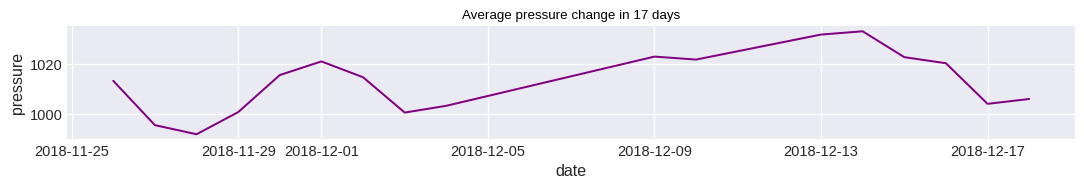

In [ ]:
plt.style.use('seaborn-darkgrid')
my_dpi=96
plt.figure(figsize=(1300/my_dpi, 150/my_dpi), dpi=my_dpi)
sns.lineplot(x=weather_date.date, y=weather_date.pressure,color='purple')
plt.title("Average pressure change in 17 days",fontsize=10, fontweight=0, color='black')
plt.show()

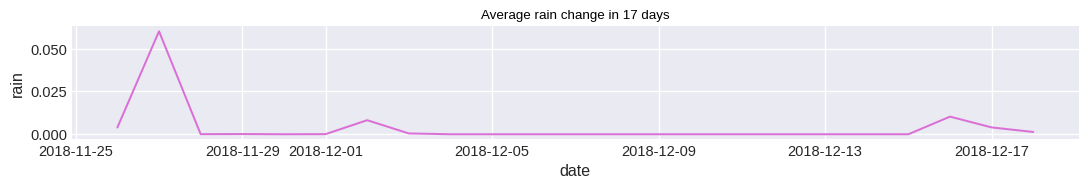

In [ ]:
plt.style.use('seaborn-darkgrid')
my_dpi=96
plt.figure(figsize=(1300/my_dpi, 150/my_dpi), dpi=my_dpi)
sns.lineplot(x=weather_date.date, y=weather_date.rain,color='orchid')
plt.title("Average rain change in 17 days",fontsize=10, fontweight=0, color='black')
plt.show()

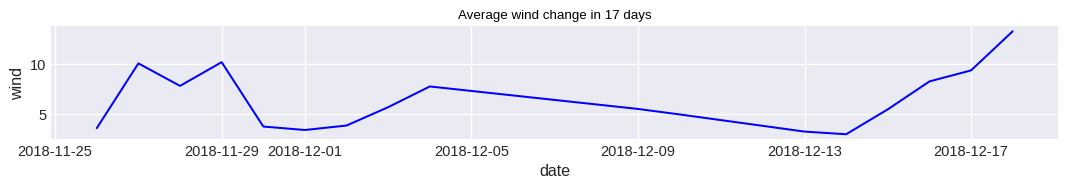

In [ ]:
plt.style.use('seaborn-darkgrid')
my_dpi=96
plt.figure(figsize=(1300/my_dpi, 150/my_dpi), dpi=my_dpi)
sns.lineplot(x=weather_date.date, y=weather_date.wind,color='blue')
plt.title("Average wind change in 17 days",fontsize=10, fontweight=0, color='black')
plt.show()

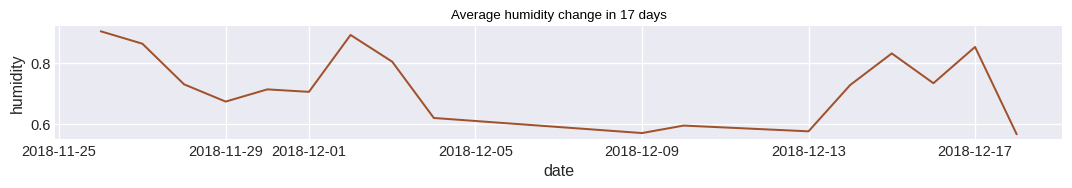

In [ ]:
plt.style.use('seaborn-darkgrid')
my_dpi=96
plt.figure(figsize=(1300/my_dpi, 150/my_dpi), dpi=my_dpi)
sns.lineplot(x=weather_date.date, y=weather_date.humidity,color='sienna')
plt.title("Average humidity change in 17 days",fontsize=10, fontweight=0, color='black')
plt.show()

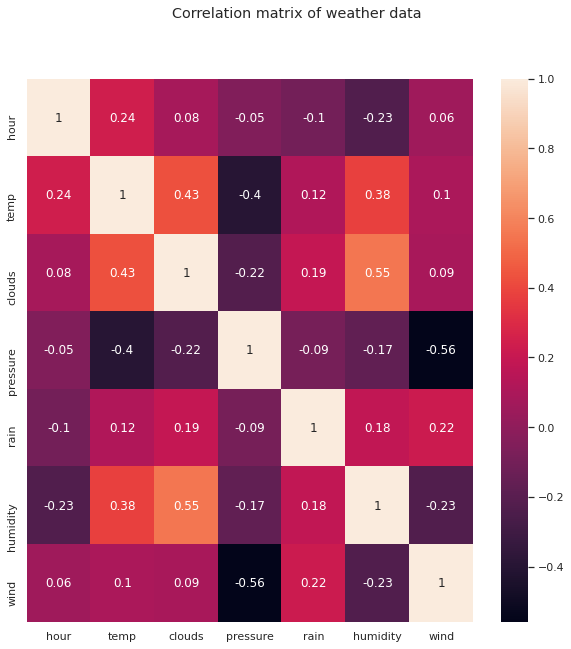

In [ ]:
corr_matrix= weather_mean.corr().round(2)
sns.set(rc={'figure.figsize': (10,10)})
sns.heatmap(corr_matrix,annot=True)
plt.suptitle('Correlation matrix of weather data')
plt.show()

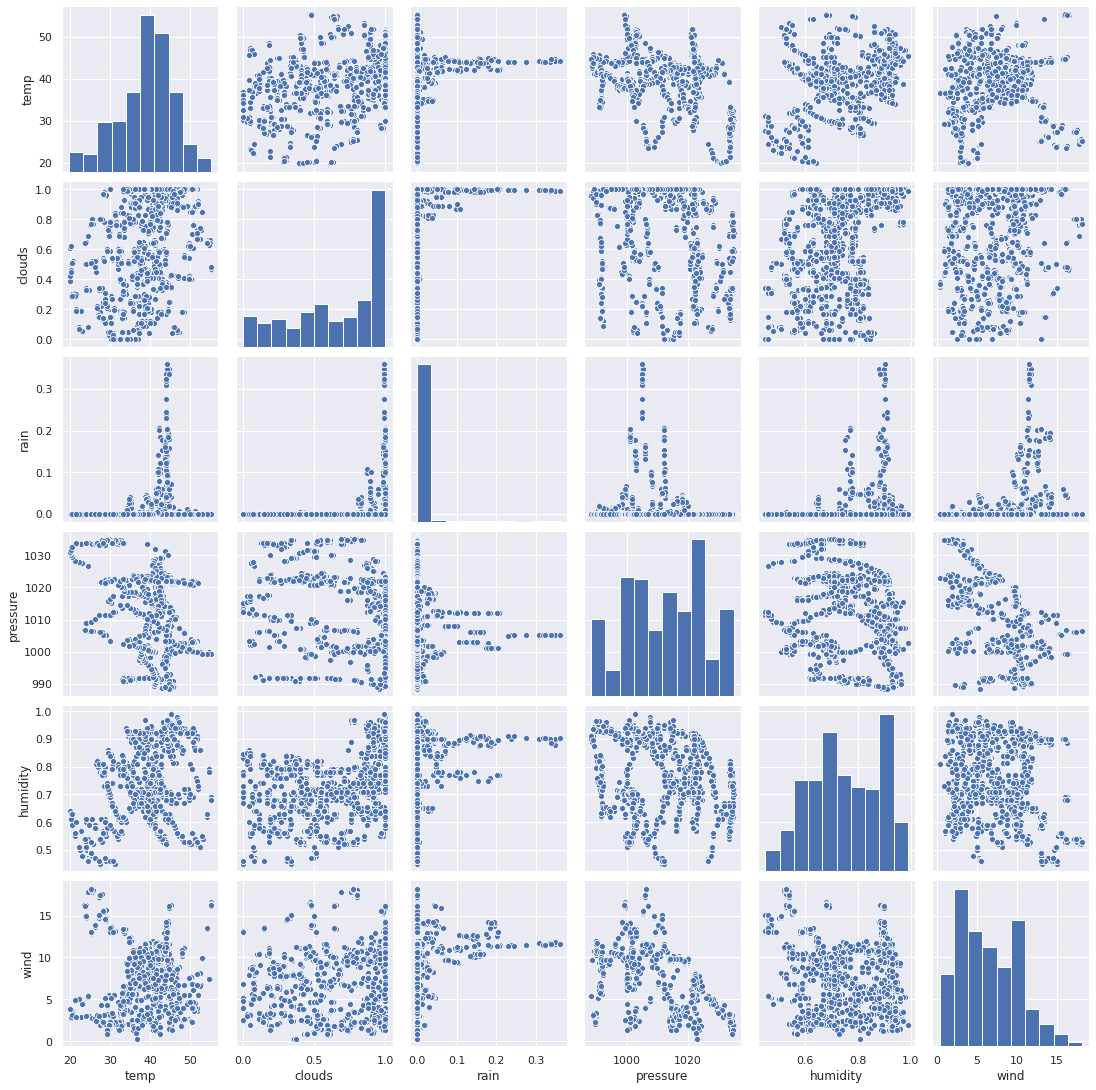

In [ ]:
sns.pairplot(weather_mean[['temp', 'clouds', 'rain', 'pressure', 'humidity', 'wind']])
plt.show()

# Cab Rides EDA
1. clean Dataset
2. some plots

In [ ]:
# change date and time format
cab['date_time'] = pd.to_datetime(cab['time_stamp']/1000, unit='s')
cab['date_time'] = cab['date_time'].dt.strftime('%Y-%m-%d %H')
cab['date_time'] = pd.to_datetime(cab['date_time'])

In [ ]:
# add DayofWeek and Hour col
cab['DayOfWeek'] = cab['date_time'].dt.dayofweek
cab['hour'] = cab['date_time'].dt.hour
cab['PricePerMile'] = cab['price']/cab['distance']
cab['name']=cab['name'].replace('Lyft','Lyft_regular')
cab["month"]=cab["date_time"].dt.month

In [ ]:
# replace DayofWeek with text
cab['DayOfWeek'] = cab['DayOfWeek'].replace(0, 'Monday')
cab['DayOfWeek'] = cab['DayOfWeek'].replace(1, 'Tuesday')
cab['DayOfWeek'] = cab['DayOfWeek'].replace(2, 'Wednesday')
cab['DayOfWeek'] = cab['DayOfWeek'].replace(3, 'Thursday')
cab['DayOfWeek'] = cab['DayOfWeek'].replace(4, 'Friday')
cab['DayOfWeek'] = cab['DayOfWeek'].replace(5, 'Saturday')
cab['DayOfWeek'] = cab['DayOfWeek'].replace(6, 'Sunday')

In [ ]:
#drop all NaNs
cab = cab.dropna()

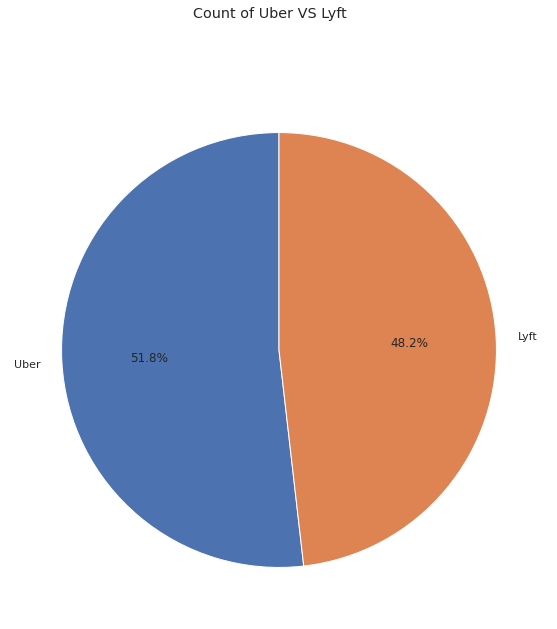

In [ ]:
# Pie: Uber v.s. Lyft
Ncab_type = [cab.cab_type[(cab.cab_type)=='Uber'].count(),
             cab.cab_type[(cab.cab_type)=='Lyft'].count()]
     
cab_type = ['Uber','Lyft']

plt.pie(Ncab_type, labels=cab_type, startangle=90, autopct='%.1f%%')
plt.suptitle('Count of Uber VS Lyft')
plt.show()

# Uber gets a more rides compared to Lyft in this particular dataset

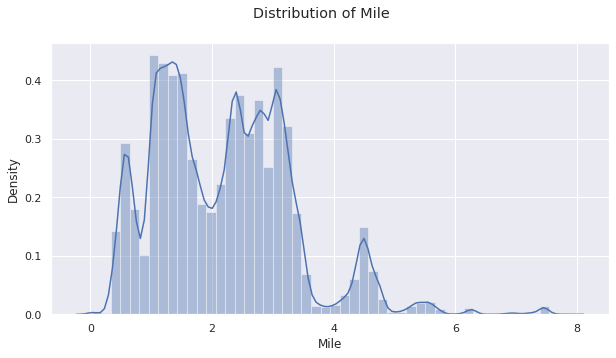

In [ ]:
# plot distance
plt.figure(figsize=(10,5))
plot_distance = sns.distplot(cab['distance'])
plot_distance.set_xlabel("Mile", fontsize=12)
plot_distance.set_ylabel("Density", fontsize=12)
plt.suptitle('Distribution of Mile')
plt.show()

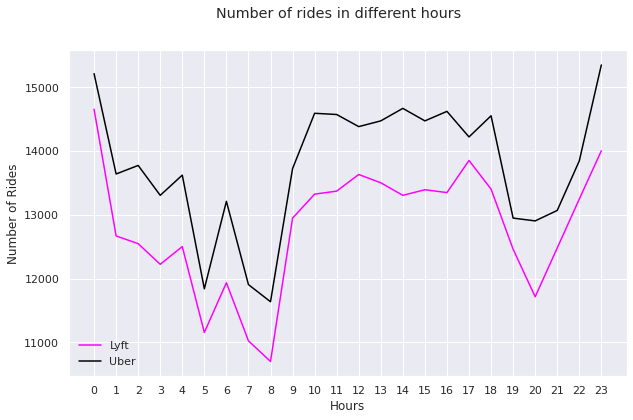

In [ ]:
# hour vs number of rides
fig , ax = plt.subplots(figsize= (10,6))
ax.plot(cab[cab['cab_type'] == 'Lyft'].groupby('hour').hour.count().index, cab[cab['cab_type'] == 'Lyft'].groupby('hour').hour.count(), label = 'Lyft',color='fuchsia')
ax.plot(cab[cab['cab_type'] == 'Uber'].groupby('hour').hour.count().index, cab[cab['cab_type'] == 'Uber'].groupby('hour').hour.count(), label = 'Uber',color='Black')
ax.set(xlabel = 'Hours', ylabel = 'Number of Rides')
ax.legend()
plt.xticks(range(0,24,1))
plt.suptitle('Number of rides in different hours')
plt.show()

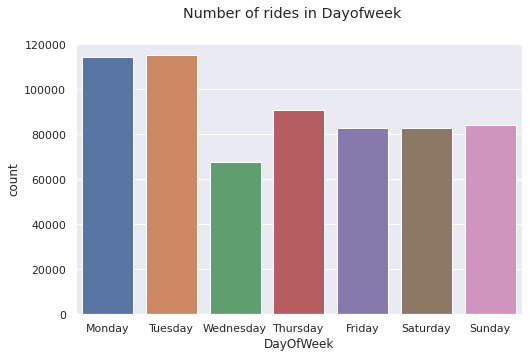

In [ ]:
# plot DayOfWeek
plt.figure(figsize=(8,5))
plot_DayOfWeek = sns.countplot(x="DayOfWeek", data=cab, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday','Saturday','Sunday'])
plt.suptitle('Number of rides in Dayofweek')
plt.show()

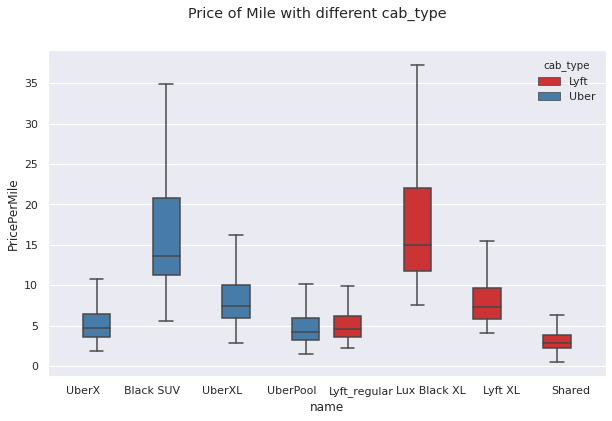

In [ ]:
# price vs service type
fig , ax = plt.subplots(figsize= (10,6))
o =['UberX', 'Black SUV', 'UberXL', 'UberPool', 'Lyft_regular', 'Lux Black XL','Lyft XL','Shared']
vis1 = sns.boxplot( data = cab, x = 'name', y = 'PricePerMile',
                   showfliers=False, hue='cab_type', order=o, palette='Set1')
plt.suptitle('Price of Mile with different cab_type')
plt.show()

Lyft has a better rate for carpool category. Lyft XL has a slightly lower fare per mile than UberXL. Uber Black SUV shows lower rate than Lyft Black XL. Lyft ordinary ride and UberX has similar rates, in which Lyft is better up till 3rd quarter of sample.

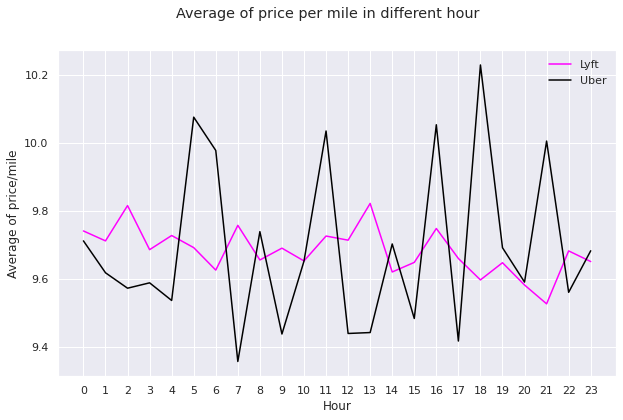

In [ ]:
# hour vs price per hour
fig , ax = plt.subplots(figsize= (10,6))
ax.plot(cab[cab['cab_type'] == 'Lyft'].groupby('hour').hour.count().index, cab[cab['cab_type'] == 'Lyft'].groupby('hour').PricePerMile.mean(), label = 'Lyft',color='fuchsia')
ax.plot(cab[cab['cab_type'] == 'Uber'].groupby('hour').hour.count().index, cab[cab['cab_type'] == 'Uber'].groupby('hour').PricePerMile.mean(), label = 'Uber',color='Black')
ax.legend()
ax.set(xlabel = 'Hour', ylabel = 'Average of price/mile')
plt.xticks(range(0,24,1))
plt.suptitle('Average of price per mile in different hour')
plt.show()

<Figure size 1900x200 with 0 Axes>

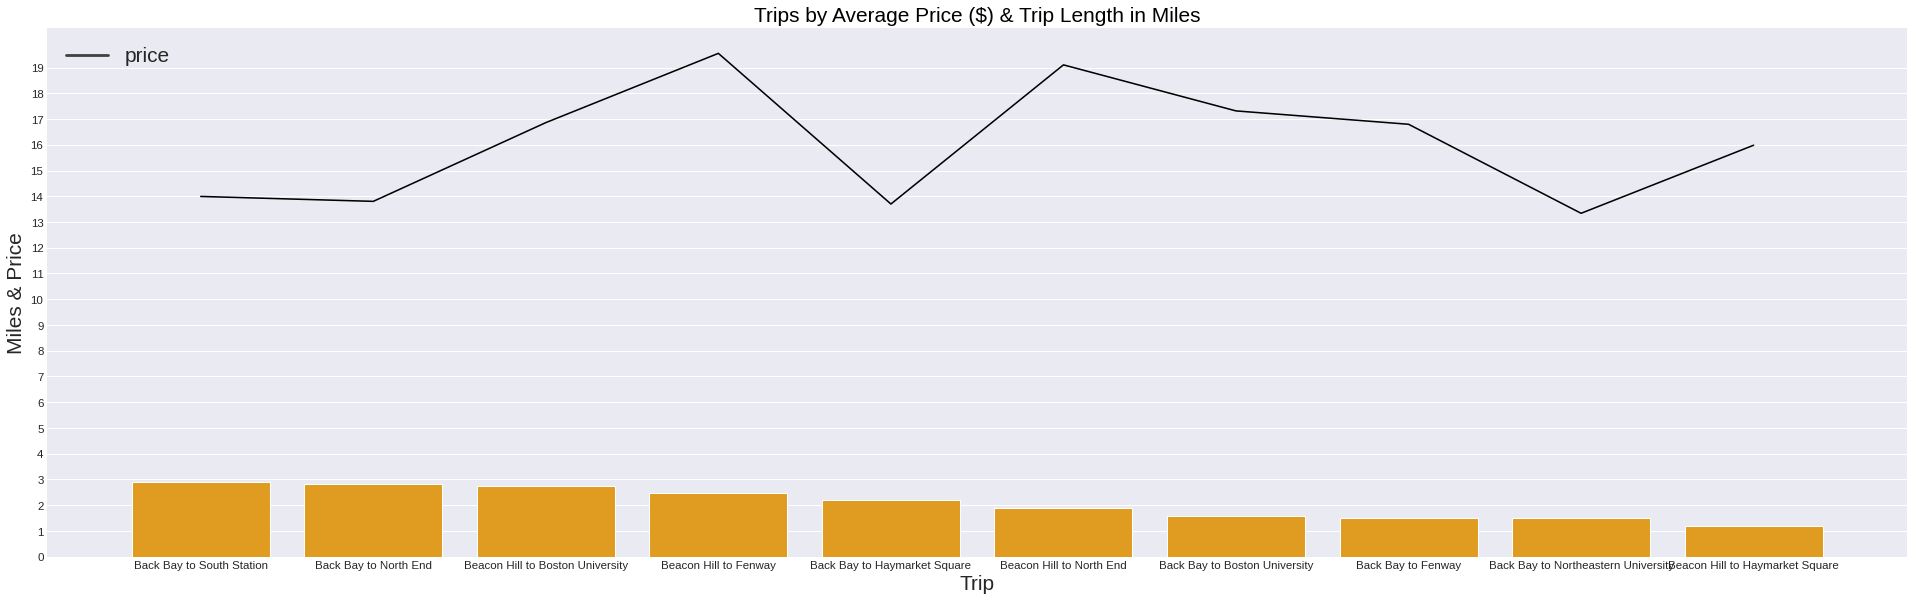

In [ ]:
#Trips by Average Price and Average Trip Length
sub_cab = cab
sub_cab['Trip'] = sub_cab['destination']+str(' to ')+sub_cab['source']
g = sub_cab.sort_values(['Trip', 'destination'], ascending=False).groupby('Trip')['distance'].mean().head(10)
h = sub_cab.sort_values(['price'], ascending=False).groupby('Trip')['price'].mean().head(10)
h = h.reset_index()
g = g.reset_index()
g = g.sort_values('distance', ascending = False)
plt.figure(figsize=(1900/my_dpi, 200/my_dpi), dpi=my_dpi)
plt.style.use('seaborn-darkgrid')
my_dpi=75
plt.figure(figsize=(2400/my_dpi, 700/my_dpi), dpi=my_dpi)
sns.barplot(x=g.Trip, y=g.distance,color='orange')
sns.lineplot(x=h.Trip, y = h.price, color = 'black')
plt.legend(['price'], loc = 'upper left', fontsize = '20')
plt.title("Trips by Average Price ($) & Trip Length in Miles",fontsize=20, fontweight=3, color = 'black')
plt.xlabel("Trip", fontsize = '20')
plt.ylabel("Miles & Price", fontsize = '20')
plt.yticks(range(0,20,1))
plt.show()
# % of days with percipitation vs no percipatation
# % of days with wind vs no wind
# average distane per group

in Dec which route people are more likely to choose 

In [ ]:
dec_data = cab[cab["month"]==12]
route_data = pd.DataFrame(dec_data.groupby(["destination","source"])["price"].count()).sort_values(by="price",ascending=False)
route_data.reset_index()
top10_route = route_data.iloc[:10,:]
top10_route.rename(columns={"price":"count_num"},inplace=True)
top10_route

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,,count_num
destination,source,
Financial District,South Station,5630
South Station,Financial District,5616
West End,Fenway,5565
Haymarket Square,Financial District,5553
Theatre District,Boston University,5516
North End,Back Bay,5502
Fenway,West End,5502
Financial District,Haymarket Square,5490
Boston University,West End,5478


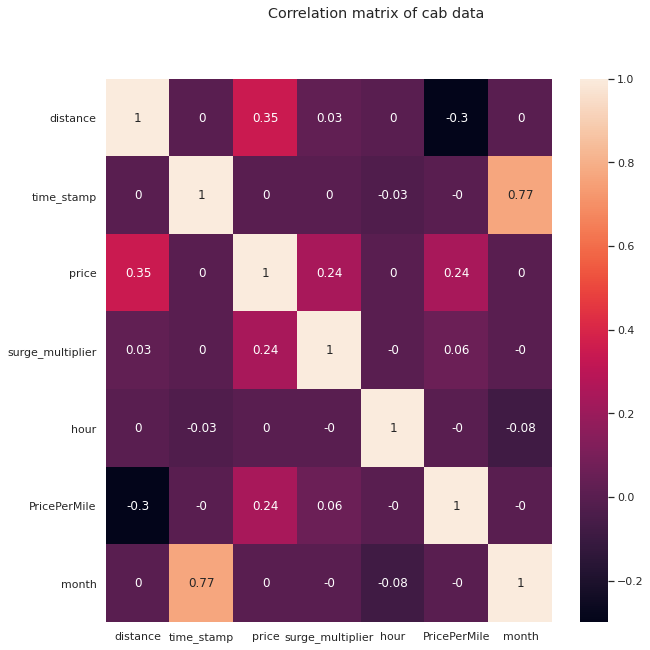

In [ ]:
correlation_matrix = cab.corr().round(2)
correlation_matrix

# specify dimensions of plot
sns.set(rc={'figure.figsize':(10,10)})
# make plot
sns.heatmap(data=correlation_matrix, annot=True)
plt.suptitle('Correlation matrix of cab data')
plt.show()

# Merge: Weather and Cab

1. merge weather mean and cab dataset
2. drop unnecessary features
3. build the feature: hour and dayofweek

In [ ]:
#create join columns on dataset for future merge by using location + condensing the original date time to day and hour
cab['date_location'] = cab.source.astype(str) +" - "+ cab.date_time.dt.date.astype(str) +" - "+ cab.date_time.dt.hour.astype(str)
weather_mean['date_location'] = weather_mean.location.astype(str) +" - "+ weather_mean.date.astype(str)+" - "+ weather_mean.hour.astype(str)

In [ ]:
cab.head()

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name,date_time,DayOfWeek,hour,PricePerMile,month,Trip,date_location
0,0.44,Lyft,1544952607890,North Station,Haymarket Square,5.0,1.0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,lyft_line,Shared,2018-12-16 09:00:00,Sunday,9,11.363636,12,North Station to Haymarket Square,Haymarket Square - 2018-12-16 - 9
1,0.44,Lyft,1543284023677,North Station,Haymarket Square,11.0,1.0,4bd23055-6827-41c6-b23b-3c491f24e74d,lyft_premier,Lux,2018-11-27 02:00:00,Tuesday,2,25.000000,11,North Station to Haymarket Square,Haymarket Square - 2018-11-27 - 2
2,0.44,Lyft,1543366822198,North Station,Haymarket Square,7.0,1.0,981a3613-77af-4620-a42a-0c0866077d1e,lyft,Lyft_regular,2018-11-28 01:00:00,Wednesday,1,15.909091,11,North Station to Haymarket Square,Haymarket Square - 2018-11-28 - 1
3,0.44,Lyft,1543553582749,North Station,Haymarket Square,26.0,1.0,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,lyft_luxsuv,Lux Black XL,2018-11-30 04:00:00,Friday,4,59.090909,11,North Station to Haymarket Square,Haymarket Square - 2018-11-30 - 4
4,0.44,Lyft,1543463360223,North Station,Haymarket Square,9.0,1.0,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,lyft_plus,Lyft XL,2018-11-29 03:00:00,Thursday,3,20.454545,11,North Station to Haymarket Square,Haymarket Square - 2018-11-29 - 3


In [ ]:
#perform merge
cab_total= pd.merge(cab,weather_mean,left_on='date_location',right_on='date_location',how='inner') 

In [ ]:
# drop missing values from merged dataframe
cab_total= cab_total.dropna(axis=0).reset_index(drop=True)
cab_total


,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name,date_time,DayOfWeek,hour_x,PricePerMile,month,Trip,date_location,location,date,hour_y,temp,clouds,pressure,rain,humidity,wind
0,0.44,Lyft,1544952607890,North Station,Haymarket Square,5.0,1.0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,lyft_line,Shared,2018-12-16 09:00:00,Sunday,9,11.363636,12,North Station to Haymarket Square,Haymarket Square - 2018-12-16 - 9,Haymarket Square,2018-12-16,9,38.460000,0.290000,1022.250000,0.0,0.760000,7.680000
1,1.33,Lyft,1544952309308,Beacon Hill,Haymarket Square,7.0,1.0,0d468502-34b5-447f-be9f-acbb62176072,lyft,Lyft_regular,2018-12-16 09:00:00,Sunday,9,5.263158,12,Beacon Hill to Haymarket Square,Haymarket Square - 2018-12-16 - 9,Haymarket Square,2018-12-16,9,38.460000,0.290000,1022.250000,0.0,0.760000,7.680000
2,0.53,Lyft,1544951109578,North Station,Haymarket Square,27.5,1.0,2aa8d17e-4b13-4200-87db-db3eed73ca6b,lyft_luxsuv,Lux Black XL,2018-12-16 09:00:00,Sunday,9,51.886792,12,North Station to Haymarket Square,Haymarket Square - 2018-12-16 - 9,Haymarket Square,2018-12-16,9,38.460000,0.290000,1022.250000,0.0,0.760000,7.680000
3,2.36,Lyft,1544954108860,Back Bay,Haymarket Square,7.0,1.0,4944c164-0463-47b9-96e1-15ffe8b9c7c9,lyft_line,Shared,2018-12-16 09:00:00,Sunday,9,2.966102,12,Back Bay to Haymarket Square,Haymarket Square - 2018-12-16 - 9,Haymarket Square,2018-12-16,9,38.460000,0.290000,1022.250000,0.0,0.760000,7.680000
4,0.62,Uber,1544954108161,West End,Haymarket Square,10.5,1.0,b1c23003-39fb-4030-9961-4f3420b23907,6f72dfc5-27f1-42e8-84db-ccc7a75f6969,UberXL,2018-12-16 09:00:00,Sunday,9,16.935484,12,West End to Haymarket Square,Haymarket Square - 2018-12-16 - 9,Haymarket Square,2018-12-16,9,38.460000,0.290000,1022.250000,0.0,0.760000,7.680000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635237,4.35,Lyft,1543395299476,Financial District,Fenway,30.0,1.0,6556d35f-b79f-4fa5-9f89-1fc369526ae6,lyft_lux,Lux Black,2018-11-28 08:00:00,Wednesday,8,6.896552,11,Financial District to Fenway,Fenway - 2018-11-28 - 8,Fenway,2018-11-28,8,34.526667,0.521667,991.761667,0.0,0.801667,5.526667
635238,4.35,Lyft,1543395299476,Financial District,Fenway,13.5,1.0,8930600e-295a-473a-a537-fb365d7035c7,lyft,Lyft_regular,2018-11-28 08:00:00,Wednesday,8,3.103448,11,Financial District to Fenway,Fenway - 2018-11-28 - 8,Fenway,2018-11-28,8,34.526667,0.521667,991.761667,0.0,0.801667,5.526667
635239,1.50,Uber,1543395299987,Back Bay,Fenway,7.5,1.0,a1067621-1724-4996-92d0-9812ccfc87e0,9a0e7b09-b92b-4c41-9779-2ad22b4d779d,WAV,2018-11-28 08:00:00,Wednesday,8,5.000000,11,Back Bay to Fenway,Fenway - 2018-11-28 - 8,Fenway,2018-11-28,8,34.526667,0.521667,991.761667,0.0,0.801667,5.526667
635240,1.50,Uber,1543395299987,Back Bay,Fenway,18.5,1.0,bc305791-0669-482c-aece-715df42fb45c,6c84fd89-3f11-4782-9b50-97c468b19529,Black,2018-11-28 08:00:00,Wednesday,8,12.333333,11,Back Bay to Fenway,Fenway - 2018-11-28 - 8,Fenway,2018-11-28,8,34.526667,0.521667,991.761667,0.0,0.801667,5.526667


##Merge EDA

In [ ]:
cab_total['Rain_Indicator'] = np.where(cab_total.rain != 0,'Rainy Day','Dry Day')
rain = cab_total.Rain_Indicator.value_counts().to_frame()

print(cab_total['price'].mean())

g = cab_total[cab_total['Rain_Indicator'] == 'Rainy Day' ]

print(g['price'].mean())





16.54408316830436
16.520626740691878


In [ ]:
# drop unnecessary features
cab_total= cab_total.drop(['time_stamp', 'id', 'product_id','location','hour_x','hour_y','DayOfWeek','PricePerMile','month','Rain_Indicator'], axis=1)
cab_total['date_time'] = pd.to_datetime(cab_total['date_time'])


In [ ]:
#build the feature 
cab_total['hour'] = cab_total.date_time.dt.hour
cab_total['day'] = cab_total.date_time.dt.dayofweek

In [ ]:
cab_total.head()

cab_total

,distance,cab_type,destination,source,price,surge_multiplier,name,date_time,Trip,date_location,date,temp,clouds,pressure,rain,humidity,wind,hour,day
0,0.44,Lyft,North Station,Haymarket Square,5.0,1.0,Shared,2018-12-16 09:00:00,North Station to Haymarket Square,Haymarket Square - 2018-12-16 - 9,2018-12-16,38.460000,0.290000,1022.250000,0.0,0.760000,7.680000,9,6
1,1.33,Lyft,Beacon Hill,Haymarket Square,7.0,1.0,Lyft_regular,2018-12-16 09:00:00,Beacon Hill to Haymarket Square,Haymarket Square - 2018-12-16 - 9,2018-12-16,38.460000,0.290000,1022.250000,0.0,0.760000,7.680000,9,6
2,0.53,Lyft,North Station,Haymarket Square,27.5,1.0,Lux Black XL,2018-12-16 09:00:00,North Station to Haymarket Square,Haymarket Square - 2018-12-16 - 9,2018-12-16,38.460000,0.290000,1022.250000,0.0,0.760000,7.680000,9,6
3,2.36,Lyft,Back Bay,Haymarket Square,7.0,1.0,Shared,2018-12-16 09:00:00,Back Bay to Haymarket Square,Haymarket Square - 2018-12-16 - 9,2018-12-16,38.460000,0.290000,1022.250000,0.0,0.760000,7.680000,9,6
4,0.62,Uber,West End,Haymarket Square,10.5,1.0,UberXL,2018-12-16 09:00:00,West End to Haymarket Square,Haymarket Square - 2018-12-16 - 9,2018-12-16,38.460000,0.290000,1022.250000,0.0,0.760000,7.680000,9,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635237,4.35,Lyft,Financial District,Fenway,30.0,1.0,Lux Black,2018-11-28 08:00:00,Financial District to Fenway,Fenway - 2018-11-28 - 8,2018-11-28,34.526667,0.521667,991.761667,0.0,0.801667,5.526667,8,2
635238,4.35,Lyft,Financial District,Fenway,13.5,1.0,Lyft_regular,2018-11-28 08:00:00,Financial District to Fenway,Fenway - 2018-11-28 - 8,2018-11-28,34.526667,0.521667,991.761667,0.0,0.801667,5.526667,8,2
635239,1.50,Uber,Back Bay,Fenway,7.5,1.0,WAV,2018-11-28 08:00:00,Back Bay to Fenway,Fenway - 2018-11-28 - 8,2018-11-28,34.526667,0.521667,991.761667,0.0,0.801667,5.526667,8,2
635240,1.50,Uber,Back Bay,Fenway,18.5,1.0,Black,2018-11-28 08:00:00,Back Bay to Fenway,Fenway - 2018-11-28 - 8,2018-11-28,34.526667,0.521667,991.761667,0.0,0.801667,5.526667,8,2


In [ ]:
#cab_total = cab.to_csv ('/content/drive/My Drive/Uconn BAPM/OPIM 5512/cab_total.csv', index = False, header=True)

# Preprocessing 




```
# This is formatted as code
```

1. Recode the name column 
2. Polynomial feature
3. Min_max scaler

### Recode 

In [ ]:
#dropping unessicary attributes from dataframe in preperation for modeling
cab_total=cab_total.drop(['name','cab_type','destination','source','surge_multiplier','date_location','date','date_time','distance','Trip'], axis=1)
cab_total

,price,temp,clouds,pressure,rain,humidity,wind,hour,day
0,5.0,38.460000,0.290000,1022.250000,0.0,0.760000,7.680000,9,6
1,7.0,38.460000,0.290000,1022.250000,0.0,0.760000,7.680000,9,6
2,27.5,38.460000,0.290000,1022.250000,0.0,0.760000,7.680000,9,6
3,7.0,38.460000,0.290000,1022.250000,0.0,0.760000,7.680000,9,6
4,10.5,38.460000,0.290000,1022.250000,0.0,0.760000,7.680000,9,6
...,...,...,...,...,...,...,...,...,...
635237,30.0,34.526667,0.521667,991.761667,0.0,0.801667,5.526667,8,2
635238,13.5,34.526667,0.521667,991.761667,0.0,0.801667,5.526667,8,2
635239,7.5,34.526667,0.521667,991.761667,0.0,0.801667,5.526667,8,2
635240,18.5,34.526667,0.521667,991.761667,0.0,0.801667,5.526667,8,2


In [ ]:
cab_merge.head()

In [ ]:
#creating x and y partitions to determine preliminary OLS Regression Results
x = cab_total.drop('price',axis=1)
y = cab_total.values[:,1]


In [ ]:
#running OLS regrression
x_constant = sm.add_constant(x)
cab_model = sm.OLS(y, x).fit()
cab_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          5.170e+33
Date:                Wed, 29 Apr 2020   Prob (F-statistic):                        0.00
Time:                        01:23:26   Log-Likelihood:                      1.7832e+07
No. Observations:              635242   AIC:                                 -3.566e+07
Df Residuals:                  635234   BIC:                                 -3.566e+07
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
temp           1.0000   3.53e-17   2.83e+16      0.000       1.000       1.000
clouds     -1.482e-14   8.03e-16    -18.460      0.000   -1.64e-14   -1.32e-14
pressure    -9.92e-17   1.74e-18    -57.065      0.000   -1.03e-16   -9.58e-17
rain        3.176e-15   6.73e-15      0.472      0.637      -1e-14    1.64e-14
humidity    3.585e-14   2.11e-15     16.977      0.000    3.17e-14       4e-14
wind        1.101e-15    6.4e-17     17.200      0.000    9.75e-16    1.23e-15
hour       -1.361e-15   3.19e-17    -42.646      0.000   -1.42e-15    -1.3e-15
day        -1.072e-15   1.07e-16    -10.052      0.000   -1.28e-15   -8.63e-16
==============================================================================
Omnibus:                   144783.648   Durbin-Watson:                   0.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            27146.497
Skew:                           0.088   Prob(JB):                         0.00
Kurtosis:                       2.003   Cond. No.                     3.48e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.48e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Polynomial Feature 

In [ ]:
# create the polynomialfeature  with a degree of 2
poly_features = PolynomialFeatures(degree=2,interaction_only=True)
x_poly = poly_features.fit_transform(x)
x_poly = pd.DataFrame(x_poly)
x_poly= x_poly.reset_index(drop=True,inplace=False)
print(x_poly.shape)

(635242, 37)


In [ ]:
#total shape of explanatory variables
x_total= pd.concat([x,x_poly],axis=1)
print(x_total.shape)

(635242, 45)


### Min-max Scaler

In [ ]:
#normalize data prior to modeling
min_max_scaler = preprocessing.MinMaxScaler()
X_scaled = min_max_scaler.fit_transform(x_total)
x_total = pd.DataFrame(X_scaled)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(x_total, y, test_size=0.2, random_state=42)

# Model

1. spot checking 
2. hyperparameter tuning
3. Feature Importance

### Spot checking

In [ ]:

models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('GBM', GradientBoostingRegressor()))

In [ ]:
scoring = 'neg_root_mean_squared_error'
results = []
names = []
for name, model in models:
	kfold = KFold(n_splits=10, random_state=42, shuffle=True)
	cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring= scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)

LR: -0.000000 (0.000000)
LASSO: -5.401901 (0.021928)
EN: -5.554131 (0.019179)
CART: -0.000018 (0.000001)
GBM: -0.054359 (0.000379)


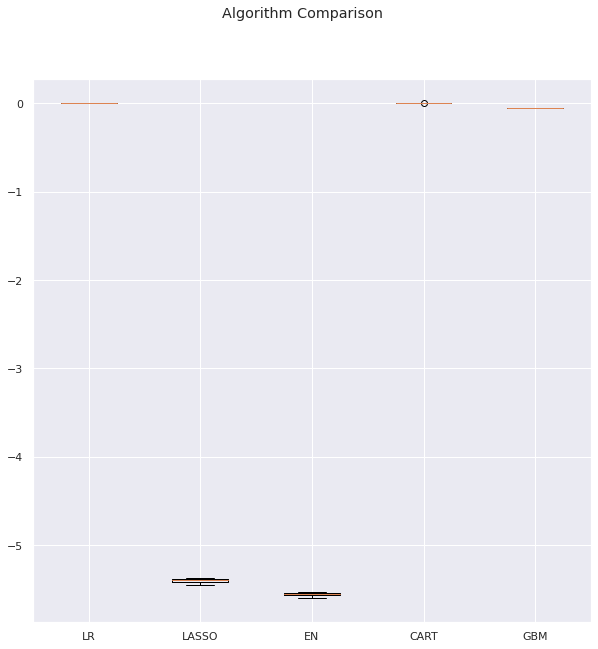

In [ ]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

###Hyperparameter Tuning

In [ ]:
# Linear is our best model
model = LinearRegression()
scoring = 'neg_root_mean_squared_error'
parameters = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
grid = GridSearchCV(estimator=model,
			param_grid=parameters,scoring = scoring)

In [ ]:
grid.fit(X_train, Y_train)
print('Best R2: %.3f' % grid.best_score_)
print('\nBest params:\n', grid.best_params_)

Best R2: -0.000

Best params:
 {'copy_X': True, 'fit_intercept': True, 'normalize': False}


### RMSE and results plot

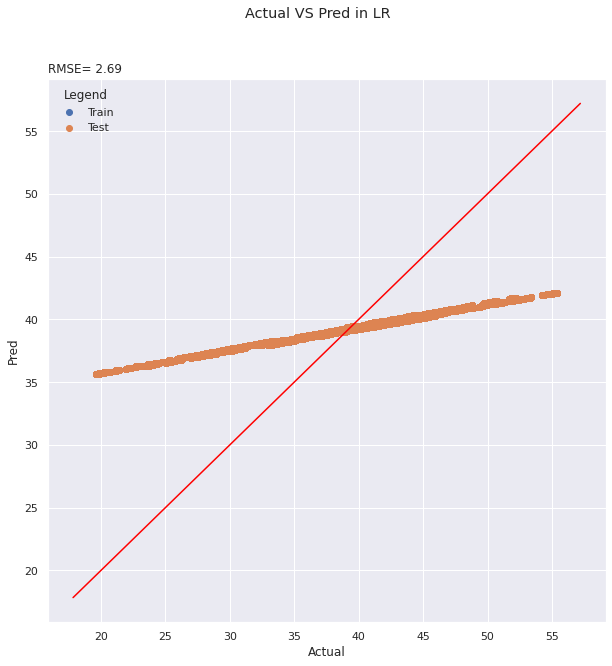

In [ ]:
LinearModel = Lasso()
LinearModel.fit(X_train,Y_train)
Y_Training_Predictions = LinearModel.predict(X_train)
Y_Testing_Predicitons= LinearModel.predict(X_test)
plt.scatter(x=Y_train, y=Y_Training_Predictions)
plt.scatter(x=Y_test,y=Y_Testing_Predicitons)
plt.legend(title ='Legend', loc = 'upper left', labels = ['Train','Test'])
plt.suptitle("Actual VS Pred in LR")
plt.title("RMSE= 2.69",loc='left')
plt.xlabel("Actual")
plt.ylabel("Pred")
X = np.linspace(*plt.xlim())
plt.plot(X, X, color='red')
RMSE = np.sqrt(mean_squared_error(Y_train,Y_Training_Predictions))
RMAE = np.sqrt(mean_absolute_error(Y_test,Y_Testing_Predicitons))
MAE = np.sqrt(mean_absolute_error(Y_test,Y_Testing_Predicitons))

In [ ]:
print(RMSE)
print(RMAE)
print(MAE)

5.4019067554524245
2.0278299216476023
2.0278299216476023


0        -0.081339
1         0.064082
2        -0.115446
3        -0.242351
4        -0.032295
            ...   
127044   -0.096543
127045    0.016004
127046   -0.148475
127047   -0.127164
127048   -0.353423
Name: Error, Length: 127049, dtype: float64

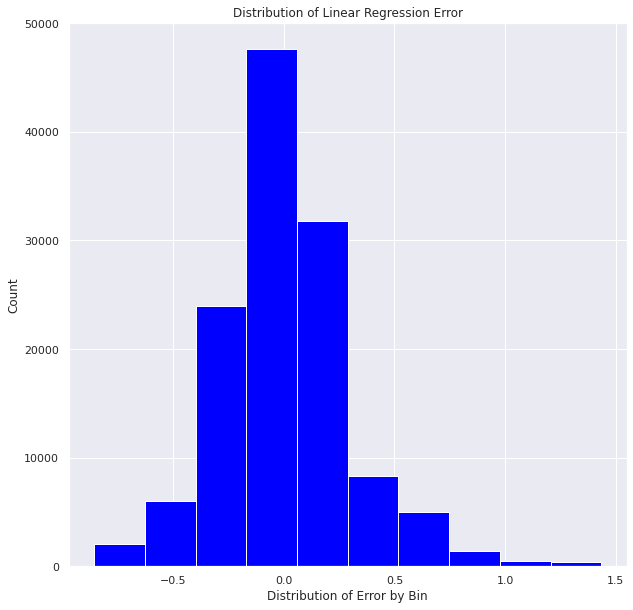

In [ ]:
Y_Pred = pd.DataFrame(Y_Testing_Predicitons)
Y_Actuals = pd.DataFrame(Y_test)

Y_Actuals = Y_Actuals.rename(columns = {0:'Actuals'})
Y_Pred = Y_Pred.rename(columns = {0:'Predictions'})

dataframe = pd.concat([Y_Pred,Y_Actuals], axis =1)

dataframe['Error'] = dataframe.Actuals-dataframe.Predictions
sub = dataframe[(dataframe['Error'] < 4)]
plt.hist(sub['Error'], bins =10 , color = 'blue')
plt.title("Distribution of Linear Regression Error")
plt.xlabel("Distribution of Error by Bin")
plt.ylabel("Count")
dataframe['Error'] 

### Feature Importance 

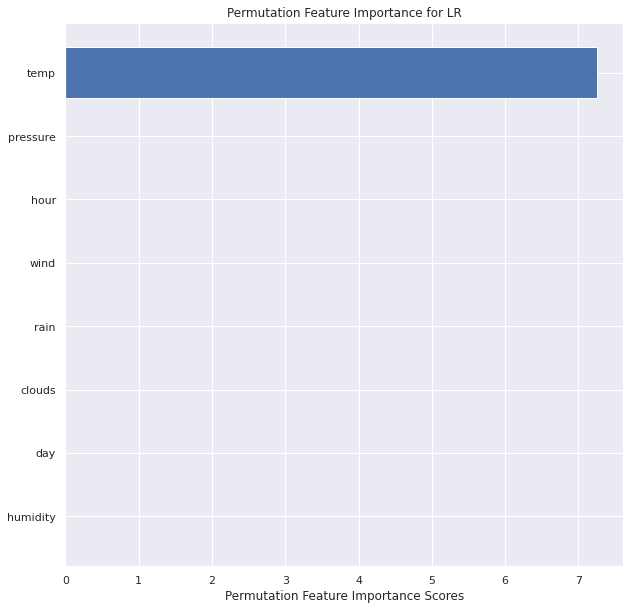

In [ ]:
#feature importance
LinearModel.fit(x,y)
num = 10
result1 = permutation_importance(LinearModel, x, y, scoring='neg_mean_absolute_error')
importance = result1.importances_mean
sorted_idx = np.argsort(importance)[-num:]
pos = np.arange(sorted_idx.shape[0]) + .5
plt.barh(pos[-num:], importance[sorted_idx], align='center')
plt.yticks(pos[-num:], x.columns[sorted_idx])
plt.xlabel('Permutation Feature Importance Scores')
plt.title('Permutation Feature Importance for LR')
plt.show()

#TSFresh 

In [ ]:
!pip install tsfresh
import tsfresh

In [ ]:
merge_date=cab_total.drop(['name','cab_type','destination','source','surge_multiplier','date_location','date','day'], axis=1)

KeyError: ignored

In [ ]:
merge_date.head()

In [ ]:
merge_date.index = merge_date['date_time']
tmp = merge_date.resample('60T').mean()
print(tmp.shape)

In [ ]:
tmp = tmp.dropna()
tmp['Date'] = tmp.index

In [ ]:
x1 = tmp.drop('price',axis=1)

In [ ]:
x1.head()

In [ ]:
y1 = tmp.groupby(['Date'], sort=False)['price'].mean()
y1.head()

In [ ]:
extracted_features = extract_features(x1, 
                                      column_id="Date")

In [ ]:
print(y1.shape)
y1.reset_index
extracted_features.reset_index

In [ ]:
impute(extracted_features)
features_filtered = select_features(extracted_features, y1)
print(extracted_features.shape)

In [ ]:
print(features_filtered.shape)
features_filtered.head()

In [ ]:
x_20 = features_filtered
y1.head()

In [ ]:
print(x_20.shape)
print(y1.shape)

In [ ]:
# standardize the x data
x_train, x_test, y_train, y_test = train_test_split(x_20, y1, test_size=0.3, random_state=0)

### RandomForest

In [ ]:
RidgeModel = RandomForestRegressor (random_state=42)
RidgeModel.fit(x_train,y_train)
RF_Training_Predictions = RidgeModel.predict(x_train)
RF_Testing_Pred= RidgeModel.predict(x_test)

In [ ]:
plt.scatter(x= y_train, y= RF_Training_Predictions)
plt.scatter(x= y_test, y= RF_Testing_Pred)
plt.legend(title ='Legend', loc = 'upper left', labels = ['Train','Test'])
X = np.linspace(*plt.xlim())
plt.plot(X, X, color='red')
plt.suptitle("Actual VS Pred in RF")
plt.title("RMSE= 0.274",loc='left')
plt.xlabel("Actual")
plt.ylabel("Pred")
RMSE_RF = np.sqrt(mean_squared_error(y_test,RF_Testing_Pred))
RMAE_RF = np.sqrt(mean_absolute_error(y_test,RF_Testing_Pred))
MAE_RF = np.abs(mean_squared_error(y_test,RF_Testing_Pred))

In [ ]:
print(RMSE_RF)
print(RMAE_RF)
print(MAE_RF)

### Netural Network

In [ ]:
model = Sequential()
model.add(layers.Dense(1200, activation='relu',input_shape=(x_train.shape[1],)))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(126, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(1))

In [ ]:
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

In [ ]:
es = EarlyStopping(monitor='mae', 
                   mode='min', 
                   patience=50, 
                   verbose=1)

history = model.fit(x_train, y_train,
          validation_data=(x_test, y_test), 
          epochs=5000,  
          batch_size=20,  
          callbacks=[es],
          verbose=1) 

In [ ]:
model.fit(x_train,y_train)
nn_Training_Predictions = model.predict(x_train)
nn_Testing_Pred= model.predict(x_test)

In [ ]:
plt.scatter(x=y_train, y= nn_Training_Predictions)
plt.scatter(x=y_test, y= nn_Testing_Pred)
plt.legend(title ='Legend', loc = 'upper left', labels = ['Train','Test'])
X = np.linspace(*plt.xlim())
plt.plot(X, X, color='red')
plt.suptitle("Actual VS Pred in NN")
plt.title("RMSE= 0.741",loc='left')
plt.xlabel("Actual")
plt.ylabel("Pred")
RMSE_NN = np.sqrt(mean_squared_error(y_test,nn_Testing_Pred))
RMAE_NN = np.sqrt(mean_absolute_error(y_test,nn_Testing_Pred))
MAE_NN= np.abs(mean_squared_error(y_test,nn_Testing_Pred))

In [ ]:
print(RMSE_NN)
print(RMAE_NN)
print(MAE_NN)

### Linear Regression

In [ ]:
model2 = LinearRegression ()
model2.fit(x_train,y_train)
LR_Training_Predictions = model2.predict(x_train)
LR_Testing_Pred= model2.predict(x_test)

In [ ]:
plt.scatter(x= y_train,y= LR_Training_Predictions)
plt.scatter(x= y_test, y= LR_Testing_Pred)
plt.legend(title ='Legend', loc = 'upper left', labels = ['Train','Test'])
X = np.linspace(*plt.xlim())
plt.plot(X, X, color='red')
plt.suptitle("Actual VS Pred in LR (TSfresh)")
plt.title("RMSE= 0.263",loc='left')
plt.xlabel("Actual")
plt.ylabel("Pred")
RMSE_LR = np.sqrt(mean_squared_error(y_test,LR_Testing_Pred))
RMAE_LR = np.sqrt(mean_absolute_error(y_test,LR_Testing_Pred))
MAE_LR = np.abs(mean_squared_error(y_test,LR_Testing_Pred))

In [ ]:
print(RMSE_LR)
print(RMAE_LR)
print(MAE_LR)

### Feature important for LR Tfresh 

In [ ]:
model2.fit(x_train,y_train)
num = 9
result1 = permutation_importance(model2, x_train, y_train, scoring='neg_mean_absolute_error')
importance = result1.importances_mean
sorted_idx = np.argsort(importance)[-num:]
pos = np.arange(sorted_idx.shape[0]) + .5
plt.barh(pos[-num:], importance[sorted_idx], align='center')
plt.yticks(pos[-num:], x_train.columns[sorted_idx])
plt.xlabel('Permutation Feature Importance Scores')
plt.title('Permutation Feature Importance for LR (TSfresh)')
plt.show()